In [1]:
import json, sys
from tqdm import tqdm
import re
from collections import Counter
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np
import sys

In [2]:
# Function to get the correct answer
def get_gold(query_data, query):
  for q in query_data:
    if q['query'] == query:
      return q['answer']
  return ''

# Function to compute ROUGE scores
def comp_rouge_metrics(pred_list, gold_list):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge1_list = []
    rougeL_list = []
    
    for pred, gold in zip(pred_list, gold_list):
        scores = scorer.score(gold, pred)
        rouge1_list.append(scores['rouge1'].fmeasure)
        rougeL_list.append(scores['rougeL'].fmeasure)
    
    avg_rouge1 = sum(rouge1_list) / len(rouge1_list)
    avg_rougeL = sum(rougeL_list) / len(rougeL_list)
    
    return avg_rouge1, avg_rougeL

# Function to compute BLEU scores
def comp_bleu_metrics(pred_list, gold_list):
    smoothing = SmoothingFunction().method1  # Smoothing to handle edge cases
    bleu_scores = []
    for pred, gold in zip(pred_list, gold_list):
        reference = [gold.split()]  # BLEU expects list of lists for reference
        candidate = pred.split()
        score = sentence_bleu(reference, candidate, smoothing_function=smoothing)
        bleu_scores.append(score)
    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    return avg_bleu

# Function to check if there is an intersection of words between two strings
def has_intersection(a, b):
  a_words = set(a.split())
  b_words = set(b.split())
  return len(a_words.intersection(b_words)) > 0

def get_idx(x,alist):
  for i,c in enumerate(alist):
    if c == x:
      return i
  return -1

def count_overlap(gold,pred):
  # Standardise by removing all non-alphanumeric characters.
  # The input should be lower cased. But to be safe ...
  g = gold.lower()
  p = pred.lower()
  cg = re.sub(r'[^A-Za-z0-9 ]+', '', g)
  cp = re.sub(r'[^A-Za-z0-9 ]+', '', p)
  gold_words = cg.split()
  pred_words = cp.split()
  glen = len(gold_words)
  plen = len(pred_words)

  # Somewhat destructive as it removes dupes, but is the only sensible way
  # to do it.
  #gold_words = list(set(gold_words))
  #pred_words = list(set(pred_words))
  cnt = 0
  for w in pred_words:
    rv = get_idx(w,gold_words)
    if rv != -1:
      cnt += 1
      v = gold_words.pop(rv)
  return cnt, glen, plen 

# Function to extract the answer from gold
def extract_answer(input_string):
  match = re.search(r'The answer to the question is "(.*?)"', input_string)
  return match.group(1) if match else input_string

def comp_metrics_new(pred_list, gold_list):
  prec_list = []
  recall_list = []
  f1_list = []
  for gold, pred in zip(gold_list, pred_list):
    c, plen, glen = count_overlap(gold,pred)

    # Compute Precision Directly
    if plen == 0:
      precision = 0.0
    else:
      precision = float(c)/plen

    # Compute Recall Directly
    if glen == 0:
      recall = 0
    else:
      recall = float(c)/glen

    if precision == 0.0 and recall == 0.0:
      f1 = 0.0
    else:
      f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    prec_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

  # You can modify this code easily to get the list of per query scores for all
  # three metrics.
  micro_prec = sum(prec_list)/len(prec_list)
  micro_recall = sum(recall_list)/len(recall_list)
  micro_f1 = sum(f1_list)/len(f1_list)

  return micro_prec, micro_recall, micro_f1


# Function to calculate evaluation metrics
def comp_metrics(pred_list, gold_list):
  tp = sum(1 for pred, gold in zip(pred_list, gold_list) 
           if has_intersection(pred.lower(), gold.lower()))
  fp = sum(1 for pred, gold in zip(pred_list, gold_list) 
           if not has_intersection(pred.lower(), gold.lower()))
  fn = len(gold_list) - tp
  #print ('{} {} {}'.format(tp, fp, fn))
  #print (len(gold_list))
  #print (len(pred_list))
  precision = tp / (tp + fp) if tp + fp > 0 else 0
  recall = tp / (tp + fn) if tp + fn > 0 else 0
  f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
  return precision, recall, f1

def run_evaluation(predictions, gold_labels):
  # Read files
  with open(predictions, 'r') as fh:
    data = fh.read()
    doc_data = json.loads(data)

  #with open('dataset/MultiHopRAG.json', 'r') as file:
  with open(gold_labels, 'r') as fh:
    data = fh.read()
    query_data = json.loads(data)

  # Initialize dictionary to save lists of predictions and gold standards 
  # for each question_type
  type_data = {}
  overall_pred_list = []
  overall_gold_list = []

  #print(doc_data)
  # Main loop, iterate through document data
  for d in tqdm(doc_data):
    model_answer = d['model_answer']
    if 'The answer' in model_answer:
      model_answer = extract_answer(model_answer)
    gold = get_gold(query_data,d['query'])
    if gold:
      question_type = d['question_type']
      if question_type not in type_data:
        type_data[question_type] = {'pred_list': [], 'gold_list': []}
      type_data[question_type]['pred_list'].append(model_answer)
      type_data[question_type]['gold_list'].append(gold)
      overall_pred_list.append(model_answer)
      overall_gold_list.append(gold)

  dictlist = [dict() for x in range(5)]
  i = 0
  # Output evaluation data for each question_type
  for question_type, data in type_data.items():
    precision, recall, f1 = comp_metrics_new(data['pred_list'], data['gold_list'])
    rouge1, rougeL = comp_rouge_metrics(data['pred_list'], data['gold_list'])
    bleu = comp_bleu_metrics(data['pred_list'], data['gold_list'])
    # print(f"Question Type: {question_type}")
    # print(f" Precision: {precision:.2f}")
    # print(f" Recall: {recall:.2f}")
    # print(f" F1 Score: {f1:.2f}")
    # print(f" ROUGE-1: {rouge1:.2f}")
    # print(f" ROUGE-L: {rougeL:.2f}")
    # print(f" BLEU: {bleu:.2f}")
    # print()
    dictlist[i] = {
        'Name': question_type,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'ROUGE-1': rouge1,
        'ROUGE-L': rougeL,
        'BLEU': bleu
    }
    i += 1

  # Calculate overall evaluation metrics
  overall_precision, overall_recall, overall_f1 = comp_metrics_new(overall_pred_list, 
                                                                   overall_gold_list)
  overall_rouge1, overall_rougeL = comp_rouge_metrics(overall_pred_list, overall_gold_list)
  overall_bleu = comp_bleu_metrics(overall_pred_list, overall_gold_list)
    
  # print(f"Overall Metrics:")
  # print(f" Precision: {overall_precision:.2f}")
  # print(f" Recall: {overall_recall:.2f}")
  # print(f" F1 Score: {overall_f1:.2f}")
  # print(f" ROUGE-1: {overall_rouge1:.2f}")
  # print(f" ROUGE-L: {overall_rougeL:.2f}")
  # print(f" BLEU: {overall_bleu:.2f}")
  dictlist[i] = {
        'Name': "Overall",
        'Precision': overall_precision,
        'Recall': overall_recall,
        'F1': overall_f1,
        'ROUGE-1': overall_rouge1,
        'ROUGE-L': overall_rougeL,
        'BLEU': overall_bleu
    }
  return dictlist

In [3]:
gold_labels = 'data/rag.json'
models_data = {
    'LLaMA-2': run_evaluation('output/llama2_7b_hf.json', gold_labels),
    'Mistral-7B': run_evaluation('output/mistral_7b_instruct_v03.json', gold_labels),
    'Starling-7B': run_evaluation('output/starling_7b_alpha.json', gold_labels),
    'Zephyr-7B-beta': run_evaluation('output/zephyr_7b_beta.json', gold_labels)
}

100%|████████████████████████████████████████████████████████████████████████████| 2556/2556 [00:00<00:00, 21869.49it/s]


In [4]:
models_data

{'LLaMA-2': [{'Name': 'inference_query',
   'Precision': 0.8255208333333334,
   'Recall': 0.6785528318437661,
   'F1': 0.6890786334186747,
   'ROUGE-1': 0.6956846301978351,
   'ROUGE-L': 0.6948512968645018,
   'BLEU': 0.17077508182058052},
  {'Name': 'comparison_query',
   'Precision': 0.20998831775700935,
   'Recall': 0.014333501733074343,
   'F1': 0.017957681517635767,
   'ROUGE-1': 0.018348903103502578,
   'ROUGE-L': 0.018348903103502578,
   'BLEU': 0.001321576339792155},
  {'Name': 'null_query',
   'Precision': 0.10631229235880399,
   'Recall': 0.009467637011354915,
   'F1': 0.016936650950290868,
   'ROUGE-1': 0.01686788998340313,
   'ROUGE-L': 0.01686788998340313,
   'BLEU': 3.3828656631878735e-05},
  {'Name': 'temporal_query',
   'Precision': 0.3149228130360206,
   'Recall': 0.018217011342602615,
   'F1': 0.0238602093622069,
   'ROUGE-1': 0.02463556340635601,
   'ROUGE-L': 0.02463556340635601,
   'BLEU': 0.0020931156995913766},
  {'Name': 'Overall',
   'Precision': 0.418221830985

In [5]:
def plot_metrics(models_data):
    query_types = ['inference_query', 'comparison_query', 'null_query', 'temporal_query', 'Overall']
    metrics = ['Precision', 'Recall', 'F1', 'ROUGE-1', 'ROUGE-L', 'BLEU']
    num_models = len(models_data)
    model_names = list(models_data.keys())
    
    # Set up figure and axes
    fig, axes = plt.subplots(len(metrics), 1, figsize=(10, len(metrics) * 5))
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        width = 0.15  # Width of bars
        x = np.arange(len(query_types))  # X-axis positions
        
        # Plot bars for each model
        for j, (model_name, data) in enumerate(models_data.items()):
            values = [entry[metric] for entry in data]
            ax.bar(x + j * width, values, width, label=model_name)
        
        # Customize plot
        ax.set_title(f'{metric} by Query Type')
        ax.set_xticks(x + width * (num_models - 1) / 2)
        ax.set_xticklabels(query_types, rotation=45)
        ax.set_ylim([0, 1])  # Assuming metric scores between 0 and 1
        ax.legend()

    plt.tight_layout()
    plt.show()

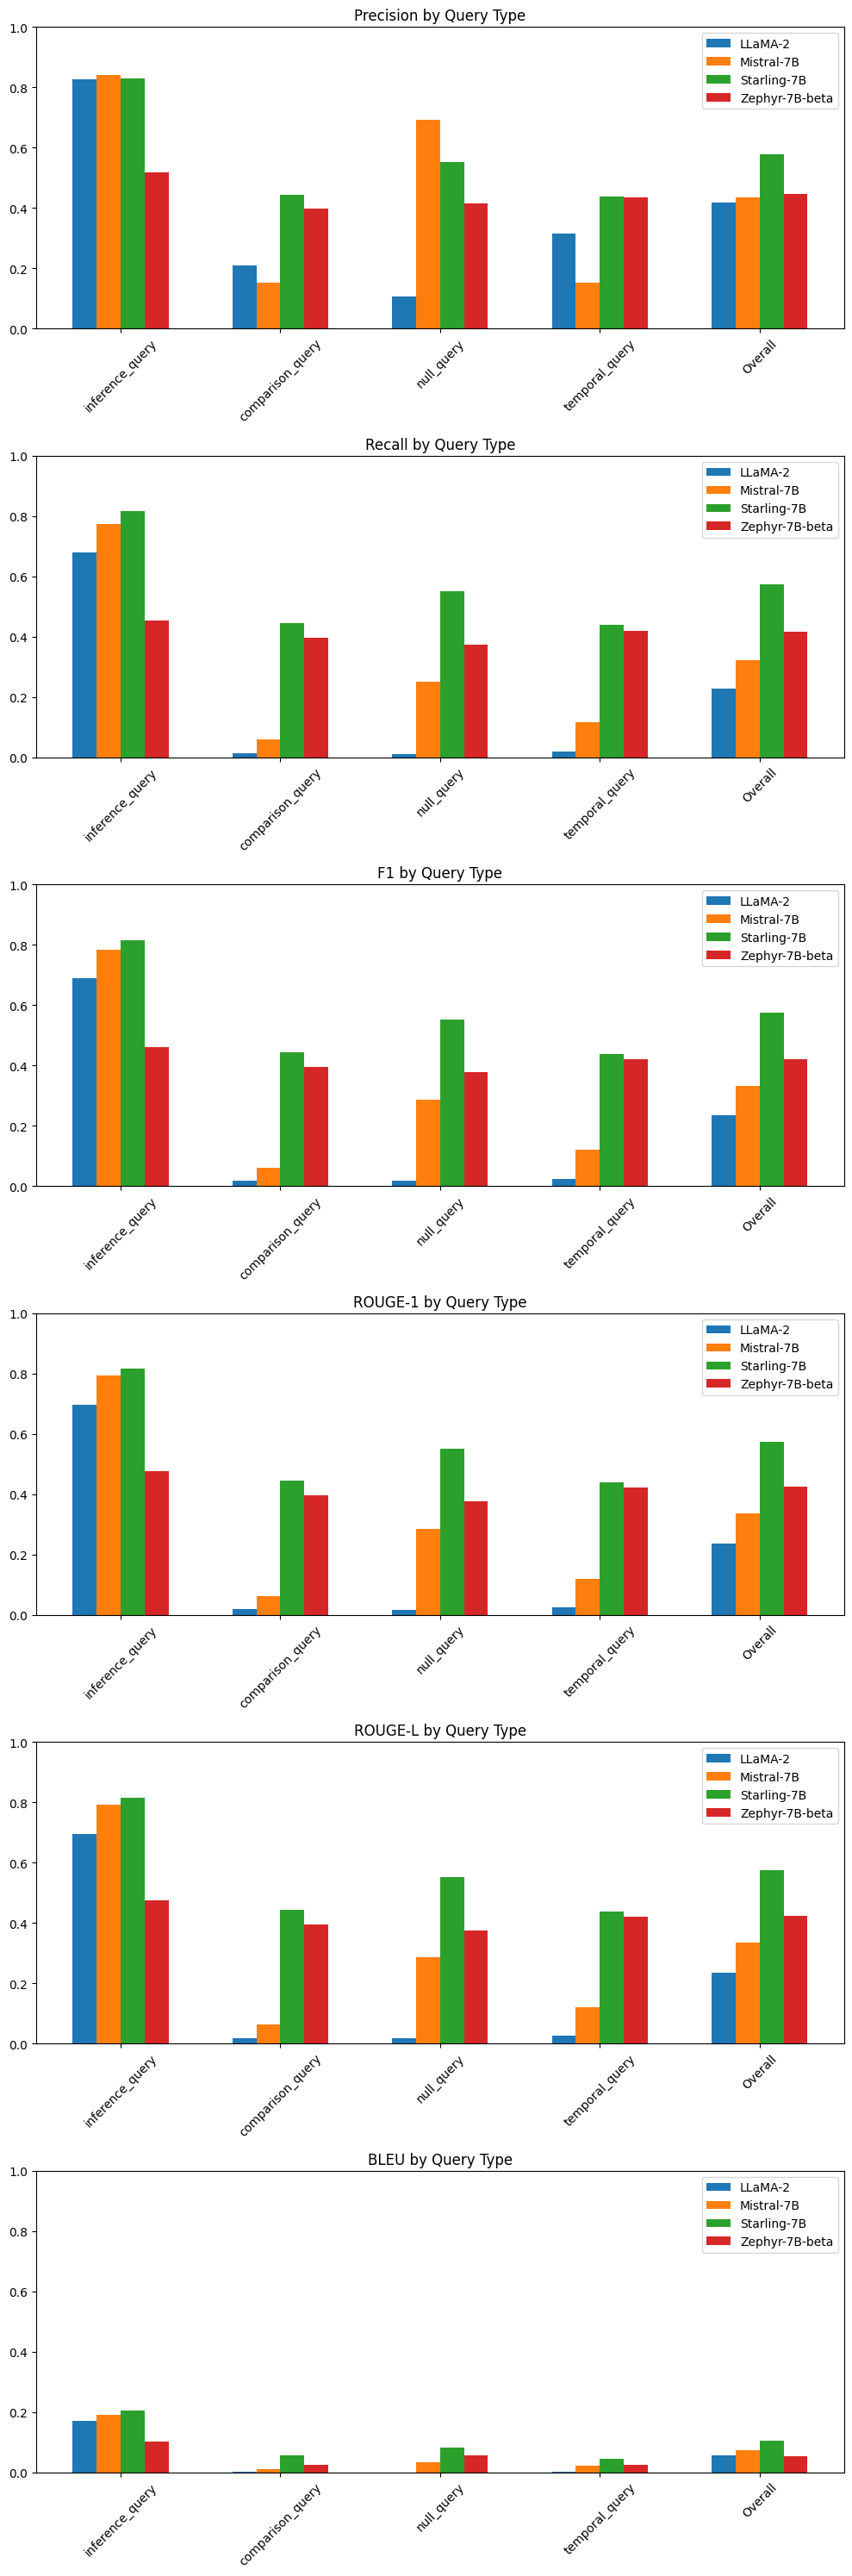

In [6]:
plot_metrics(models_data)